In [105]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle as pkl
import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50V2, DenseNet121, VGG19, EfficientNetB7, InceptionV3, MobileNetV3Large
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input, ReLU, LeakyReLU, TimeDistributed
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
import re

In [106]:
""" Dataset directories """
dataset_dir = "Segmented_dataset"
# dataset_dir = "filtered_dataset"
# dataset_dir = "archive/Data"

In [107]:
""" Get the first image from the healthy directory """
first_image_file = os.listdir(f"{dataset_dir}/No Dementia")[0]
img = plt.imread(f"{dataset_dir}/No Dementia/{first_image_file}")

img_height, img_width = img.shape

img_size = 224
# img_size = min(img_height, img_width)

print(f"Image size: {img_height}x{img_width} -> {img_size}x{img_size}")

Image size: 208x176 -> 224x224


#### General preprocessing and augmentation


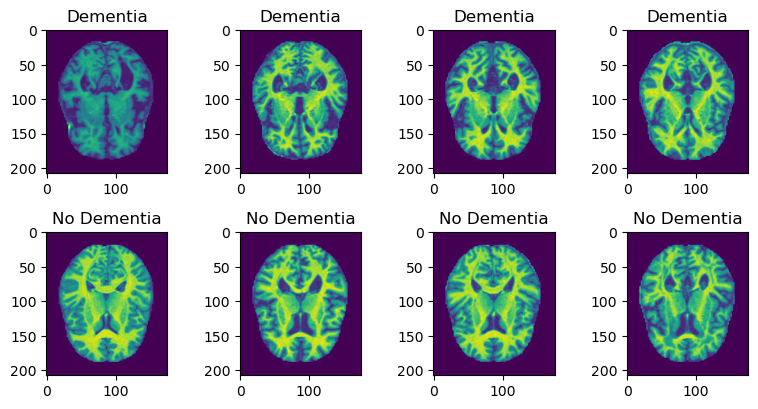

In [108]:
""" Display raw images from different classes """
plt.figure(figsize=(8, 8))

for i, subdir in enumerate(os.listdir(dataset_dir)):
    subdir_path = os.path.join(dataset_dir, subdir)
    img_files = os.listdir(subdir_path)[:4]

    for j, img_file in enumerate(img_files):
        img_path = os.path.join(subdir_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.title(subdir)

plt.tight_layout()
plt.show()

#### Custom preprocessing on Images


In [109]:
def apply_clahe(img):
    # # Convert image to grayscale
    # grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(img)

    return equalized_img


def enhance_sharpness(img):
    # Apply Laplacian sharpening to enhance details
    laplacian = cv2.Laplacian(img, cv2.CV_8U, ksize=3)

    # Add the original image with the sharpened details
    sharpened_img = cv2.addWeighted(img, 1.5, laplacian, -0.5, 0)

    return sharpened_img


def crop_image(img, add_pixels_value=1):
    # Apply Gaussian blur to reduce noise
    gray_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Thresholding to create a binary image
    _, thresh = cv2.threshold(gray_blur, 45, 255, cv2.THRESH_BINARY)

    # Morphological operations (erosion and dilation) to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # If no contours found, return original image
    if len(contours) == 0:
        return img

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add extra pixels to the bounding box if specified
    x -= add_pixels_value
    y -= add_pixels_value
    w += add_pixels_value * 2
    h += add_pixels_value * 2

    # Ensure the bounding box coordinates are within image bounds
    x = max(x, 0)
    y = max(y, 0)
    w = min(w, img.shape[1])
    h = min(h, img.shape[0])

    # Crop the image using the bounding box
    cropped_img = img[y : y + h, x : x + w].copy()

    return cropped_img


def resize_image(img, size):
    # Resize the image to the specified size
    resized_img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

    return resized_img

In [110]:
"""
    Change run cell to True if you need the preprocessed images. Then keep toggle as False to only get the final preprocessed images.
"""

prep_dir_1 = "dataset_preprocessed_1_clahe"
prep_dir_2 = "dataset_preprocessed_2_sharp"
prep_dir_3 = "dataset_preprocessed_3_crop"
prep_dir_4 = "dataset_preprocessed_4_final"

# Flag for this cell
run_cell = False

if run_cell:
    # Local save intermediate outputs toggle
    toggle = False

    # Create directories if they don't exist
    for prep_dir in [prep_dir_1, prep_dir_2, prep_dir_3, prep_dir_4]:
        if not os.path.exists(prep_dir):
            os.makedirs(prep_dir)

    for subdir in os.listdir(dataset_dir):
        subdir_path = os.path.join(dataset_dir, subdir)

        # Create subdirectories in each preprocessing directory
        for prep_dir in [prep_dir_1, prep_dir_2, prep_dir_3, prep_dir_4]:
            new_subdir_path = os.path.join(prep_dir, subdir)
            if not os.path.exists(new_subdir_path):
                os.makedirs(new_subdir_path)

        for filename in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, filename)
            img = plt.imread(img_path)

            # Apply CLAHE and save the result in prep_dir_1
            clahe_img = apply_clahe(img)
            new_filename = os.path.join(prep_dir_1, subdir, filename)
            if toggle:
                plt.imsave(new_filename, clahe_img, cmap="gray")

            # # Enhance sharpness and save the result in prep_dir_2
            # sharp_img = enhance_sharpness(clahe_img)
            # new_filename = os.path.join(prep_dir_2, subdir, filename)
            # if toggle:
            #     plt.imsave(new_filename, sharp_img, cmap="gray")

            # Crop image and save the result in prep_dir_3
            cropp_image = crop_image(clahe_img)
            new_filename = os.path.join(prep_dir_3, subdir, filename)
            if toggle:
                plt.imsave(new_filename, cropp_image, cmap="gray")

            # Resize image to 224x224 and save the result in prep_dir_4
            preprocessed_img = resize_image(cropp_image, img_size)
            new_filename = os.path.join(prep_dir_4, subdir, filename)
            plt.imsave(new_filename, preprocessed_img, cmap="gray")

prep_dir = prep_dir_4

In [111]:
# def custom_preprocess(img):
#     # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
#     clahe_img = apply_clahe(img)

#     # Enhance sharpness
#     sharp_img = enhance_sharpness(clahe_img)

#     # Crop image
#     cropped_img = crop_image(sharp_img)

#     # Resize image to 224x224
#     preprocessed_img = resize_image(cropped_img, img_size)

#     return preprocessed_img

#### Filter the Data

In [112]:
# # Given images are in naming syntax of "OAS1_0001_MR1_mpr-1_100.jpg". I want to only keep the images that end between _120.jpg and _140.jpg
# pattern = re.compile(r".*_(12[0-9]|13[0-9]|140).jpg")

# for sub_dir in os.listdir(prep_dir):
#     for img_file in os.listdir(f"{prep_dir}/{sub_dir}"):
#         if not pattern.match(img_file):
#             os.remove(f"{prep_dir}/{sub_dir}/{img_file}")

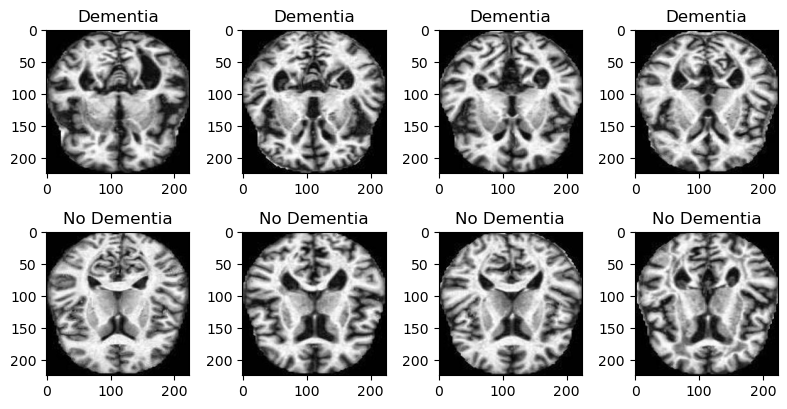

In [113]:
""" Display raw images from different classes """
plt.figure(figsize=(8, 8))

for i, subdir in enumerate(os.listdir(prep_dir)):
    subdir_path = os.path.join(prep_dir, subdir)
    img_files = os.listdir(subdir_path)[:4]

    for j, img_file in enumerate(img_files):
        img_path = os.path.join(subdir_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.title(subdir)

plt.tight_layout()
plt.show()

In [114]:
# Set batch size
batch_size = 64

In [115]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    brightness_range=[0.9, 1.1],
    validation_split=0.2,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
val_generator = val_datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=False, seed=42)

Found 5120 images belonging to 2 classes.
Found 1280 images belonging to 2 classes.


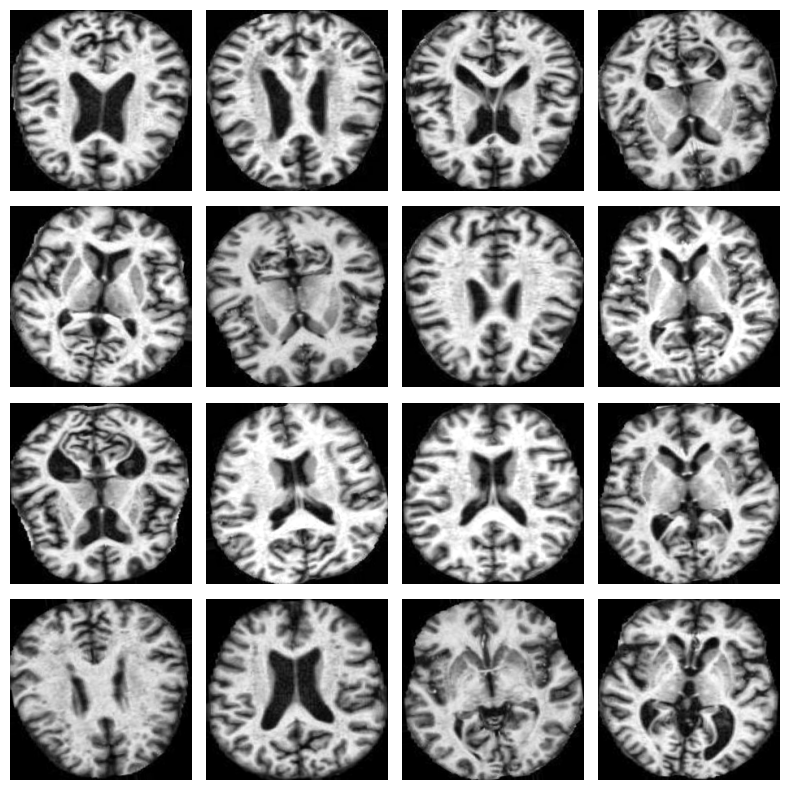

In [116]:
# Display some of the training augmented images
plt.figure(figsize=(8, 8))

for i in range(16):
    img = train_generator[0][0][i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [117]:
# # Display some of the validation augmented images
# plt.figure(figsize=(8, 8))

# for i in range(16):
#     img = val_generator[0][0][i]
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(img)
#     plt.axis("off")
    
# plt.tight_layout()
# plt.show()

In [118]:
""" Get class labels """
class_labels = list(train_generator.class_indices.keys())

In [119]:
""" Number of classes"""
num_classes = len(class_labels)

## 1. Custom CNN model


In [123]:
# Model configuration
epochs_number = 200

# Set optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Set early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='min', min_delta=0.01, restore_best_weights=True)

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, mode='min', factor=0.75, min_lr=0.00001)

# Checkpoint
checkpoint_filepath = "models/custom_CNN_model.h5"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [124]:
# Custom CNN architecture
custom_CNN_model = Sequential(
    [
        Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(img_size, img_size, 3), kernel_regularizer=L2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, (3, 3), padding="same", activation="relu", kernel_regularizer=L2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=L2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),
        Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=L2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),
        Flatten(),
        Dense(512, activation="relu", kernel_regularizer=L2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

# Compile the model
custom_CNN_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
custom_CNN_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_41 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 56, 56, 64)       

In [125]:
# Train the model
custom_CNN_history = custom_CNN_model.fit(
    train_generator, 
    epochs=epochs_number, 
    validation_data=val_generator, 
    callbacks=[model_checkpoint, learning_rate_reduction],
    # callbacks=[learning_rate_reduction, early_stopping, model_checkpoint],
)

Epoch 1/200
80/80 [==============================] - 43s 525ms/step - loss: 10.9364 - accuracy: 0.6207 - val_loss: 13.8417 - val_accuracy: 0.5000
Epoch 2/200
80/80 [==============================] - 40s 504ms/step - loss: 4.8432 - accuracy: 0.6557 - val_loss: 6.7778 - val_accuracy: 0.5000
Epoch 3/200
80/80 [==============================] - 40s 505ms/step - loss: 3.0764 - accuracy: 0.6812 - val_loss: 9.5783 - val_accuracy: 0.5000
Epoch 4/200
80/80 [==============================] - 40s 498ms/step - loss: 2.5316 - accuracy: 0.6812 - val_loss: 6.8836 - val_accuracy: 0.5000
Epoch 5/200
80/80 [==============================] - 41s 511ms/step - loss: 1.9815 - accuracy: 0.6975 - val_loss: 2.5360 - val_accuracy: 0.5000
Epoch 6/200
80/80 [==============================] - 40s 499ms/step - loss: 1.7256 - accuracy: 0.7059 - val_loss: 29.4856 - val_accuracy: 0.5000
Epoch 7/200
80/80 [==============================] - 42s 527ms/step - loss: 1.5694 - accuracy: 0.6980 - val_loss: 7.5042 - val_accura

In [126]:
# Save the trained model
custom_CNN_model.save("models/custom_CNN_model.h5")

# Save history
with open("models/custom_CNN_history.pkl", "wb") as f:
    pkl.dump(custom_CNN_history.history, f)

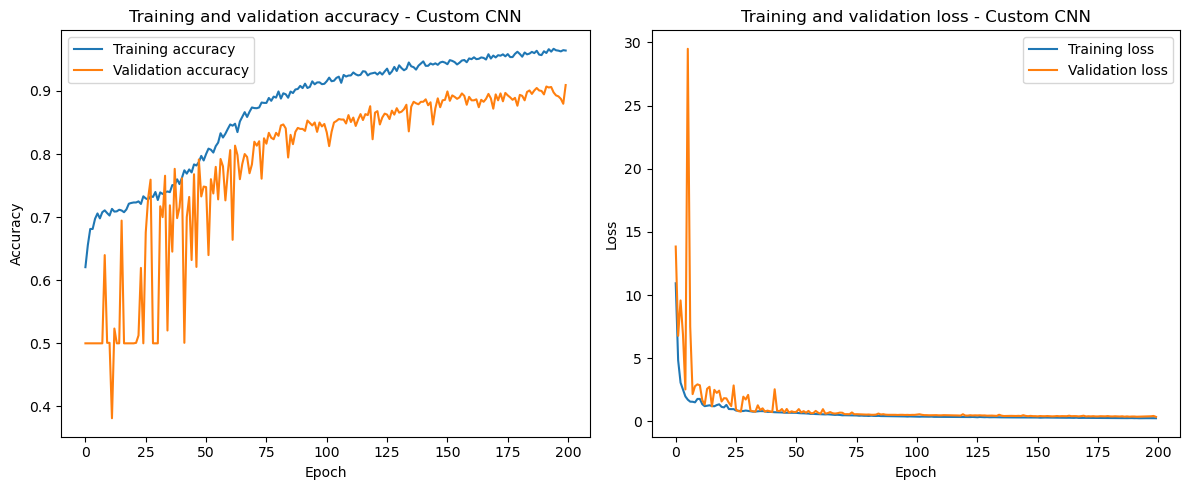

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(custom_CNN_history.history["accuracy"], label="Training accuracy")
axs[0].plot(custom_CNN_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - Custom CNN")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(custom_CNN_history.history["loss"], label="Training loss")
axs[1].plot(custom_CNN_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - Custom CNN")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

## 2. EfficientNet-B7

In [72]:
# Model configuration
epochs_number = 200

# Set optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Set early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='min', restore_best_weights=True)

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, mode='min', factor=0.75, min_lr=0.00001)

In [73]:
""" Load the EfficientNet model """
base_efficientNet_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_efficientNet_model.layers:
    layer.trainable = False

# Add custom classification head and create model
efficientNet_model = Sequential([
    base_efficientNet_model,
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=L2(0.01), activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile model
efficientNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
efficientNet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2560)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2622464   
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 2050      
Total params: 66,726,297
Trainable params: 2,626,562
Non-trainable params: 64,099,735
__________________________________

In [74]:
# Train the model
efficientNet_history = efficientNet_model.fit(
    train_generator,
    epochs=epochs_number,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
1081/1081 [==============================] - 274s 240ms/step - loss: 1.3402 - accuracy: 0.5029 - val_loss: 0.7473 - val_accuracy: 0.4984
Epoch 2/200
1081/1081 [==============================] - 254s 235ms/step - loss: 0.7281 - accuracy: 0.4977 - val_loss: 0.8072 - val_accuracy: 0.5016
Epoch 3/200
1081/1081 [==============================] - 257s 238ms/step - loss: 0.7218 - accuracy: 0.4995 - val_loss: 0.7181 - val_accuracy: 0.4984
Epoch 4/200
1081/1081 [==============================] - 257s 238ms/step - loss: 0.7174 - accuracy: 0.4996 - val_loss: 0.7426 - val_accuracy: 0.4984
Epoch 5/200
1081/1081 [==============================] - 257s 238ms/step - loss: 0.7131 - accuracy: 0.4986 - val_loss: 0.7070 - val_accuracy: 0.5016
Epoch 6/200
1081/1081 [==============================] - 260s 240ms/step - loss: 0.7096 - accuracy: 0.5029 - val_loss: 0.7041 - val_accuracy: 0.4984
Epoch 7/200
1081/1081 [==============================] - 259s 239ms/step - loss: 0.7083 - accuracy: 0.5006

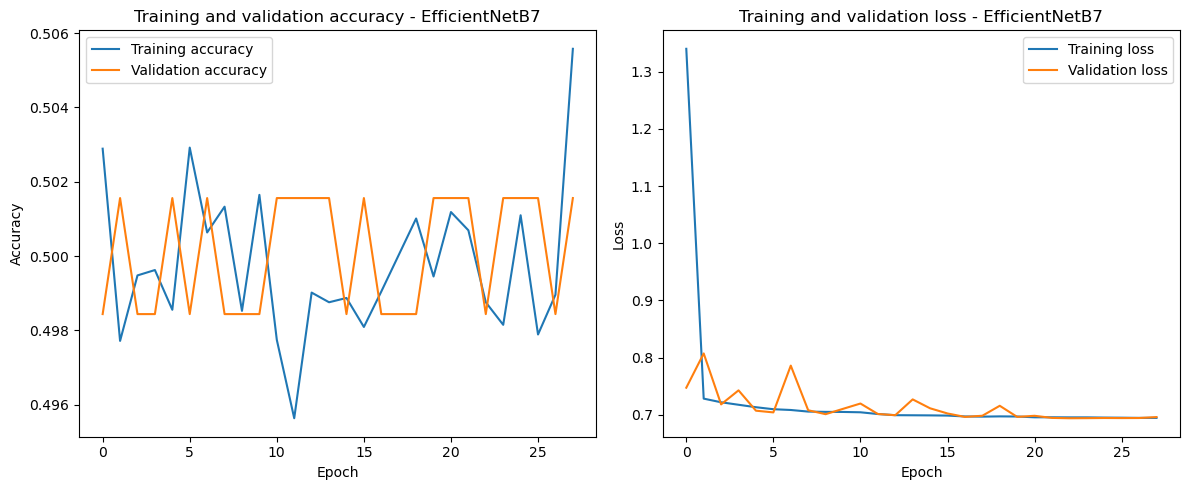

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(efficientNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(efficientNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - EfficientNetB7")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(efficientNet_history.history["loss"], label="Training loss")
axs[1].plot(efficientNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - EfficientNetB7")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [76]:
# Save trained model
efficientNet_model.save("models/efficientNet_model.h5")

# Save history
with open("models/efficientNet_history.pkl", "wb") as f:
    pkl.dump(efficientNet_history.history, f)

c:\Users\farha\miniconda3\envs\py39_env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## 3. VGG19 model

In [77]:
# Model configuration
epochs_number = 200

# Set optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Set early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='min', restore_best_weights=True)

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, mode='min', factor=0.75, min_lr=0.00001)

In [78]:
""" Load the VGG19 model """
base_vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_vgg_model.layers:
    layer.trainable = False

# Add custom classification head and create model
vgg_model = Sequential([
    base_vgg_model,
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=L2(0.01), activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile model
vgg_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
vgg_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_7 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 2050      
Total params: 20,555,842
Trainable params: 529,410
Non-trainable params: 20,026,432
____________________________________

In [79]:
# Train the model
vgg_history = vgg_model.fit(
    train_generator,
    epochs=epochs_number,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
1081/1081 [==============================] - 241s 220ms/step - loss: 1.1870 - accuracy: 0.6015 - val_loss: 1.5693 - val_accuracy: 0.5016
Epoch 2/200
1081/1081 [==============================] - 237s 219ms/step - loss: 0.7006 - accuracy: 0.6113 - val_loss: 1.2767 - val_accuracy: 0.5016
Epoch 3/200
1081/1081 [==============================] - 235s 217ms/step - loss: 0.6886 - accuracy: 0.6185 - val_loss: 0.7289 - val_accuracy: 0.5448
Epoch 4/200
1081/1081 [==============================] - 234s 217ms/step - loss: 0.6769 - accuracy: 0.6240 - val_loss: 0.7823 - val_accuracy: 0.4740
Epoch 5/200
1081/1081 [==============================] - 234s 217ms/step - loss: 0.6733 - accuracy: 0.6270 - val_loss: 1.0056 - val_accuracy: 0.4990
Epoch 6/200
1081/1081 [==============================] - 234s 216ms/step - loss: 0.6682 - accuracy: 0.6284 - val_loss: 0.7543 - val_accuracy: 0.5474

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 7/200
1081/1081 [==

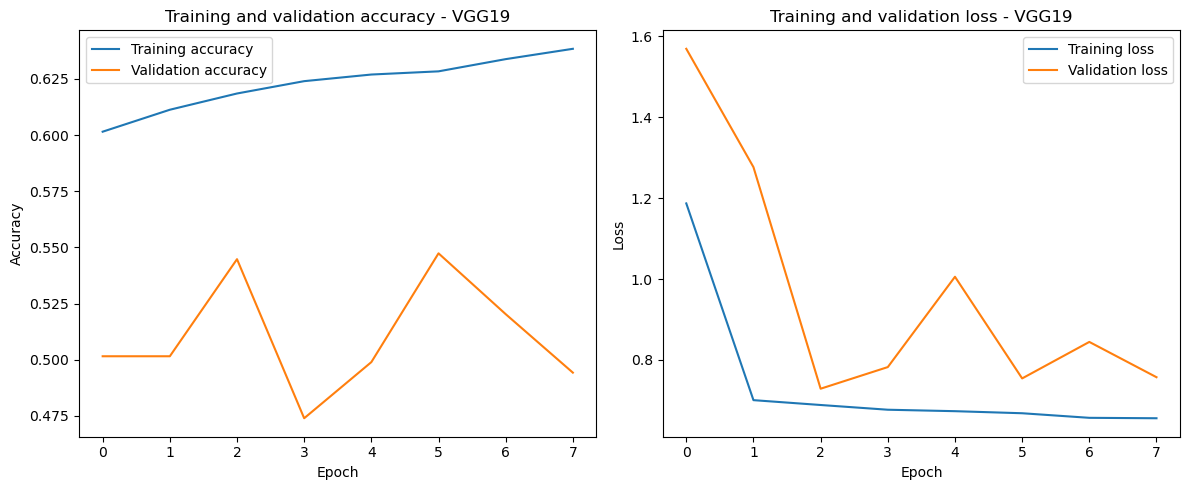

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(vgg_history.history["accuracy"], label="Training accuracy")
axs[0].plot(vgg_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - VGG19")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(vgg_history.history["loss"], label="Training loss")
axs[1].plot(vgg_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - VGG19")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [81]:
# Save the trained model
vgg_model.save("models/vgg_model.h5")

# Save the history
with open("models/vgg_history.pkl", "wb") as f:
    pkl.dump(vgg_history.history, f)

## 4. ResNet-50 V2

In [82]:
# Model configuration
epochs_number = 200

# Set optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Set early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='min', restore_best_weights=True)

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, mode='min', factor=0.75, min_lr=0.00001)

In [83]:
# Load ResNet50V2 model
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_resNet_model.layers:
    layer.trainable = False

# Add custom classification head and create model
resnet_model = Sequential([
    base_resNet_model,
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=L2(0.01), activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile model
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_8 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 2050      
Total params: 25,669,122
Trainable params: 2,102,274
Non-trainable params: 23,566,848
__________________________________

In [84]:
""" Train model """
resNet_history = resnet_model.fit(
    train_generator,
    epochs=epochs_number,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
1081/1081 [==============================] - 238s 217ms/step - loss: 1.6409 - accuracy: 0.5795 - val_loss: 0.8921 - val_accuracy: 0.4891
Epoch 2/200
1081/1081 [==============================] - 234s 217ms/step - loss: 0.7877 - accuracy: 0.5845 - val_loss: 0.8051 - val_accuracy: 0.5474
Epoch 3/200
1081/1081 [==============================] - 234s 216ms/step - loss: 0.7562 - accuracy: 0.5883 - val_loss: 0.8230 - val_accuracy: 0.5364
Epoch 4/200
1081/1081 [==============================] - 233s 215ms/step - loss: 0.7389 - accuracy: 0.5911 - val_loss: 0.9430 - val_accuracy: 0.5021
Epoch 5/200
1081/1081 [==============================] - 233s 216ms/step - loss: 0.7287 - accuracy: 0.5915 - val_loss: 0.7799 - val_accuracy: 0.5268
Epoch 6/200
1081/1081 [==============================] - 233s 216ms/step - loss: 0.7177 - accuracy: 0.5945 - val_loss: 0.7891 - val_accuracy: 0.5003
Epoch 7/200
1081/1081 [==============================] - 233s 216ms/step - loss: 0.7134 - accuracy: 0.5961

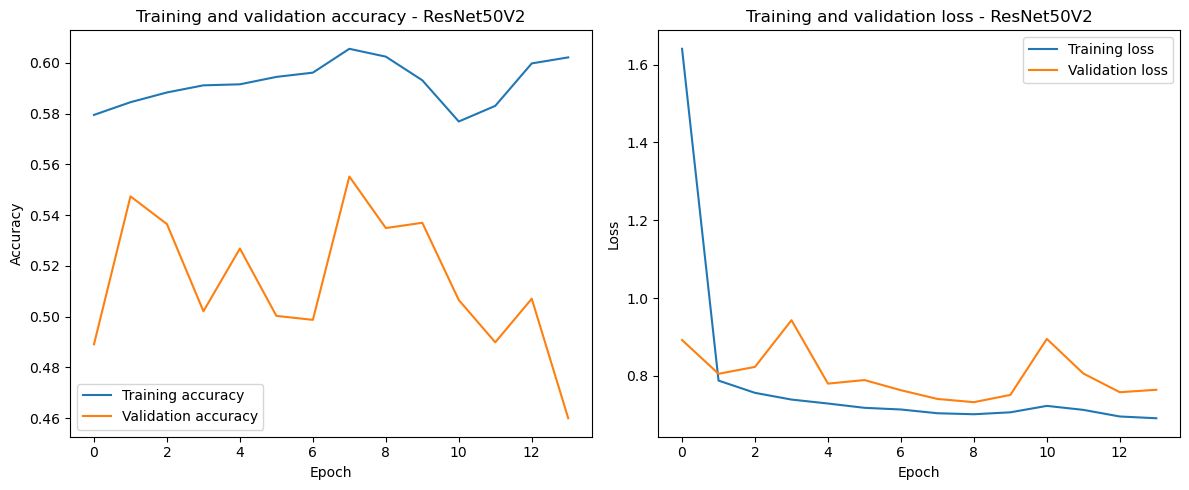

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

""" Plot training and validation accuracy """
axs[0].plot(resNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - ResNet50V2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

""" Plot training and validation loss """
axs[1].plot(resNet_history.history["loss"], label="Training loss")
axs[1].plot(resNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - ResNet50V2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [86]:
""" Save model """
resnet_model.save("models/resNet_model.h5")

""" Save history """
with open("models/resNet_history.pkl", "wb") as f:
    pkl.dump(resNet_history.history, f)

## 5. DenseNet-121 model


In [87]:
# Model configuration
epochs_number = 200

# Set optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Set early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='min', restore_best_weights=True)

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, mode='min', factor=0.75, min_lr=0.00001)

In [88]:
# Load pre-trained DenseNet121 model
base_denseNet_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_denseNet_model.layers:
    layer.trainable = False

# Add custom classification head and create model
denseNet_model = Sequential([
    base_denseNet_model,
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=L2(0.01), activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile model
denseNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
denseNet_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_9 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 2050      
Total params: 8,093,250
Trainable params: 1,053,698
Non-trainable params: 7,039,552
____________________________________

In [89]:
""" Train model """
denseNet_history = denseNet_model.fit(
    train_generator,
    epochs=epochs_number,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
1081/1081 [==============================] - 246s 222ms/step - loss: 1.4790 - accuracy: 0.5997 - val_loss: 1.2758 - val_accuracy: 0.5021
Epoch 2/200
1081/1081 [==============================] - 241s 223ms/step - loss: 0.7398 - accuracy: 0.6118 - val_loss: 1.0489 - val_accuracy: 0.5302
Epoch 3/200
1081/1081 [==============================] - 239s 221ms/step - loss: 0.7112 - accuracy: 0.6168 - val_loss: 0.8423 - val_accuracy: 0.5411
Epoch 4/200
1081/1081 [==============================] - 237s 219ms/step - loss: 0.6983 - accuracy: 0.6243 - val_loss: 0.8670 - val_accuracy: 0.5312
Epoch 5/200
1081/1081 [==============================] - 242s 224ms/step - loss: 0.6887 - accuracy: 0.6258 - val_loss: 0.7562 - val_accuracy: 0.5783
Epoch 6/200
 529/1081 [=============>................] - ETA: 2:01 - loss: 0.6864 - accuracy: 0.6223

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(denseNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(denseNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - DenseNet121")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(denseNet_history.history["loss"], label="Training loss")
axs[1].plot(denseNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - DenseNet121")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
denseNet_model.save("models/denseNet_model.h5")

# Save history
with open("models/denseNet_history.pkl", "wb") as f:
    pkl.dump(denseNet_history.history, f)

## 6. Inception-V3 model


In [ ]:
# Model configuration
epochs_number = 200

# Set optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Set early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='min', restore_best_weights=True)

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, mode='min', factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the Inception model """
base_inception_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_inception_model.layers:
    layer.trainable = False

# Add custom classification head and create model
inception_model = Sequential([
    base_inception_model,
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=L2(0.01), activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile model
inception_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
inception_model.summary()

In [ ]:
# Train the model
inception_history = inception_model.fit(
    train_generator,
    epochs=epochs_number,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(inception_history.history["accuracy"], label="Training accuracy")
axs[0].plot(inception_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - InceptionV3")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(inception_history.history["loss"], label="Training loss")
axs[1].plot(inception_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - IncetionV3")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
inception_model.save("models/inception_model.h5")

# Save history
with open("models/inception_history.pkl", "wb") as f:
    pkl.dump(inception_history.history, f)

## 7. MobileNet model


In [ ]:
# Model configuration
epochs_number = 200

# Set optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Set early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='min', restore_best_weights=True)

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, mode='min', factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the MobileNet model """
base_mobileNet_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_mobileNet_model.layers:
    layer.trainable = False

# Add custom classification head and create model
mobileNet_model = Sequential([
    base_mobileNet_model,
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=L2(0.01), activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

# Compile model
mobileNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Show model summary
mobileNet_model.summary()

In [ ]:
# Train the model
mobileNet_history = mobileNet_model.fit(
    train_generator,
    epochs=epochs_number,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
# Save trained model
mobileNet_model.save("models/mobileNet_model.h5")

# Save history
with open("models/mobileNet_history.pkl", "wb") as f:
    pkl.dump(mobileNet_history.history, f)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(mobileNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(mobileNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - MobileNetV3")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(mobileNet_history.history["loss"], label="Training loss")
axs[1].plot(mobileNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - MobileNetV3")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

## Evaluate models


In [ ]:
# Table comparing the performance of models
resNet_accuracy = resNet_history.history["accuracy"][-1]
resNet_val_accuracy = resNet_history.history["val_accuracy"][-1]

denseNet_accuracy = denseNet_history.history["accuracy"][-1]
denseNet_val_accuracy = denseNet_history.history["val_accuracy"][-1]

vgg_accuracy = vgg_history.history["accuracy"][-1]
vgg_val_accuracy = vgg_history.history["val_accuracy"][-1]

inception_accuracy = inception_history.history["accuracy"][-1]
inception_val_accuracy = inception_history.history["val_accuracy"][-1]

mobileNet_accuracy = mobileNet_history.history["accuracy"][-1]
mobileNet_val_accuracy = mobileNet_history.history["val_accuracy"][-1]

efficientNet_accuracy = efficientNet_history.history["accuracy"][-1]
efficientNet_val_accuracy = efficientNet_history.history["val_accuracy"][-1]

custom_CNN_accuracy = custom_CNN_history.history["accuracy"][-1]
custom_CNN_val_accuracy = custom_CNN_history.history["val_accuracy"][-1]

model_comparison = pd.DataFrame(
    {
        "Model": [
            "ResNet50V2",
            "DenseNet121",
            "VGG19",
            "InceptionV3",
            "MobileNetV3",
            "EfficientNetB7",
            "Custom CNN"
        ],
        "Train Accuracy": [
            resNet_accuracy,
            denseNet_accuracy,
            vgg_accuracy,
            inception_accuracy,
            mobileNet_accuracy,
            efficientNet_accuracy,
            custom_CNN_accuracy,
        ],
        "Validation Accuracy": [
            resNet_val_accuracy,
            denseNet_val_accuracy,
            vgg_val_accuracy,
            inception_val_accuracy,
            mobileNet_val_accuracy,
            efficientNet_val_accuracy,
            custom_CNN_val_accuracy,
        ],
    }
)

# Sort the models by validation accuracy
model_comparison = model_comparison.sort_values(by="Validation Accuracy", ascending=False).reset_index(drop=True)

model_comparison

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Validation Accuracy", data=model_comparison, palette="viridis")
plt.title("Comparison of Validation Accuracies")
plt.show()

In [ ]:
# import visualkeras

# model = vgg_model

# # visualkeras.layered_view(model).show()
# # visualkeras.layered_view(model, to_file='output.png')
# # visualkeras.layered_view(model, to_file='output.png').show()

# visualkeras.layered_view(model)